In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
def make_query(query, filepath='database.sqlite'):
    """
    Execute a query on a SQLite database file and return the results as a pandas DataFrame.

    Parameters
    ----------
    query : str
        SQL query to be executed on the database file.
    filepath : str, optional
        Path to the database file, by default 'database.sqlite'.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the results of the executed query.
    """
    with sqlite3.connect(filepath) as connection:
        cursor = connection.cursor()
        execution = cursor.execute(query)
        result = pd.DataFrame(execution.fetchall(), columns=[i[0] for i in execution.description])
        return result

In [3]:
def club_points_seasons(league='Premier'):
    """ 
    Generates a DataFrame containing the total points earned by each club in each season of a given league.
    
    Args:
        league : str, optional 
            The league for which to generate the points table. Defaults to 'Premier'.
        
    Returns:
        pandas.core.frame.DataFrame
            The dataframe containing the total points earned by each club in each season of the specified season.
    """    
    container = make_query(
    f"""

    SELECT DISTINCT(season), name
    FROM Match
        INNER JOIN League
            ON Match.league_id = League.id
        WHERE League.name IN (SELECT name
                              FROM League
                              WHERE name LIKE '%{league}%'
                              LIMIT 1)
    """)
    league, season = container['name'][0], list(container['season'])
    for i in range(len(season)):
        current = make_query(
        f"""

        SELECT team_long_name AS Club, SUM(wins) AS '{season[i]}'
        FROM (SELECT CASE WHEN home_team_goal > away_team_goal THEN home_team_api_id 
                          WHEN home_team_goal < away_team_goal THEN away_team_api_id END AS winners,
                     (COUNT(*) * 3) AS wins

              FROM Match
                  INNER JOIN League
                      ON league_id = League.id
                  WHERE League.name LIKE '{league}' AND season='{season[i]}'

              GROUP BY winners

              UNION

              SELECT home_draw AS Team, SUM(draws) AS Draws
              FROM (SELECT CASE WHEN home_team_goal = away_team_goal THEN home_team_api_id END AS home_draw,
                           COUNT(*) AS draws

                    FROM Match
                        INNER JOIN League
                            ON league_id = League.id
                        WHERE League.name LIKE '{league}' AND season='{season[i]}'

                    GROUP BY home_draw

                    UNION

                    SELECT CASE WHEN home_team_goal = away_team_goal THEN away_team_api_id END AS away_draw,
                           COUNT(*)

                    FROM Match
                        INNER JOIN League
                            ON league_id = League.id
                        WHERE League.name LIKE '{league}' AND season='{season[i]}'

                    GROUP BY away_draw
                   )
              GROUP BY home_draw
              )
        INNER JOIN Team
            ON winners = Team.team_api_id

        GROUP BY winners

        """
        )
        if i == 0:
            df = current
        else:
            df = df.merge(right=current, on='Club', how='outer')
            df.fillna(0, inplace=True)
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)
    return df

In [4]:
def rank(club='Manchester United', season='2008/2009'):
    """
    Retrieves the rank of a specific club in a specific season. 

    Parameters:
        club : str, optional
            The name of the club whose rank is to be retrieved. Defaults to 'Manchester United'.
        season : str, optional
            The season for which the rank is to be retrieved, in the format 'YYYY/YYYY'. Defaults to '2008/2009'.

    Returns:
        int
            The rank of the club in the season.
    """
    league, club = make_query(
    f"""

    SELECT league.name, team_long_name 

    FROM League
        INNER JOIN Match
    ON League.id = league_id
        INNER JOIN Team
    ON Match.home_team_api_id = Team.team_api_id

    WHERE team_long_name LIKE '%{club}%'
    
    LIMIT 1
    
    """).iloc[0, :]
    container = club_points_seasons(league)[season].sort_values(ascending=False).index
    for i in range(len(container)):
        if club == container[i]:
            return i + 1


In [5]:
test = club_points_seasons()
data = test.sum(axis = 1)
test['total'] = data
ranking = test
ranking.sort_values(by=['total'], ascending=False)

C:\Users\caspe\AppData\Local\Temp\ipykernel_21372\397355071.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = test.sum(axis = 1)


,Club,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,total
18,Manchester United,90,85,80,89,89,64,70,66,633
0,Chelsea,83,86,71,64,75,82,87,50,598
1,Manchester City,50,67,67,89,78,86,79,66,582
14,Arsenal,72,75,68,70,68,79,75,71,578
8,Liverpool,86,63,58,52,61,84,62,60,526
7,Tottenham Hotspur,51,70,62,69,72,66,64,70,524
13,Everton,57,61,54,56,63,72,47,47,457
16,Stoke City,45,47,46,45,42,50,54,51,380
17,Aston Villa,62,64,48,38,41,38,38,17,346
3,Sunderland,36,44,47,45,39,38,38,33,320


In [6]:
premier_league = club_points_seasons()
premier_league = premier_league.melt(id_vars='Club', var_name='Season', value_name='Points').sort_values(by=['Club', 'Season']).reset_index(drop=True)

In [7]:
team_attributes = make_query(
    f"""
    SELECT Team.team_long_name AS Club,
           CASE WHEN strftime('%m', Team_attributes.date) > '08' THEN strftime('%Y', Team_attributes.date) || '/' ||strftime('%Y', Team_attributes.date, '+1 year') 
                ELSE strftime('%Y', Team_attributes.date, '-1 year') || '/' || strftime('%Y', Team_attributes.date) END AS Season, 
           buildUpPlaySpeed,
           buildUpPlayDribblingClass,
           buildUpPlayPassing,
           buildUpPlayPositioningClass,
           chanceCreationPassing,
           chanceCreationCrossing,
           chanceCreationShooting,
           chanceCreationPositioningClass,
           defencePressure,
           defenceAggression,
           defenceTeamWidth,
           defenceDefenderLineClass
    FROM Team_attributes

    INNER JOIN Team
        USING (team_api_id)

    ORDER BY Club, Season
    """
    )

l = ['buildUpPlayPositioningClass', 'chanceCreationPositioningClass', 'defenceDefenderLineClass']

for x in l:
    current = pd.get_dummies(team_attributes[x], prefix=x[:-5], prefix_sep='', drop_first=True)
    team_attributes.drop(x, axis=1, inplace=True)
    team_attributes[current.columns[0].replace(' ', '')] = current

team_attributes['buildUpPlayDribblingClass'] = team_attributes['buildUpPlayDribblingClass'].map({'Little': 1, 'Normal': 2, 'Lots': 3})

In [8]:
premier_league_attributes = pd.merge(left=premier_league, right=team_attributes, on=['Club', 'Season'])
premier_league_attributes = premier_league_attributes[premier_league_attributes['Points'] > 0].reset_index(drop=True)
premier_league_attributes

,Club,Season,Points,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioningOrganised,chanceCreationPositioningOrganised,defenceDefenderLineOffsideTrap
0,Arsenal,2009/2010,75,66,1,30,30,45,35,30,40,50,0,0,0
1,Arsenal,2010/2011,68,75,1,40,40,45,65,50,40,45,0,0,0
2,Arsenal,2011/2012,70,25,1,32,41,34,30,57,57,52,1,0,0
3,Arsenal,2013/2014,79,30,1,29,41,55,39,64,54,52,1,0,0
4,Arsenal,2014/2015,75,59,2,26,28,55,64,51,44,52,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Wigan Athletic,2010/2011,42,35,1,50,45,65,50,45,55,65,1,1,0
116,Wigan Athletic,2011/2012,43,38,1,38,54,42,42,40,42,44,1,1,0
117,Wolverhampton Wanderers,2009/2010,38,70,1,70,70,70,70,70,70,70,1,1,0
118,Wolverhampton Wanderers,2010/2011,40,55,1,55,60,60,45,45,45,50,1,1,0


In [9]:
team_points = make_query(
    f"""
    SELECT Team.team_long_name AS Club,
           CASE WHEN strftime('%m', Team_attributes.date) > '08' THEN strftime('%Y', Team_attributes.date) || '/' ||strftime('%Y', Team_attributes.date, '+1 year') 
                ELSE strftime('%Y', Team_attributes.date, '-1 year') || '/' || strftime('%Y', Team_attributes.date) END AS Season
    FROM Team_attributes

    INNER JOIN Team
        USING (team_api_id)

    ORDER BY Club, Season
    """
    )


In [10]:
punten = pd.merge(left=premier_league, right=team_points, on=['Club', 'Season'])
punten = punten[punten['Points'] > 0].reset_index(drop=True)
punten

,Club,Season,Points
0,Arsenal,2009/2010,75
1,Arsenal,2010/2011,68
2,Arsenal,2011/2012,70
3,Arsenal,2013/2014,79
4,Arsenal,2014/2015,75
...,...,...,...
115,Wigan Athletic,2010/2011,42
116,Wigan Athletic,2011/2012,43
117,Wolverhampton Wanderers,2009/2010,38
118,Wolverhampton Wanderers,2010/2011,40


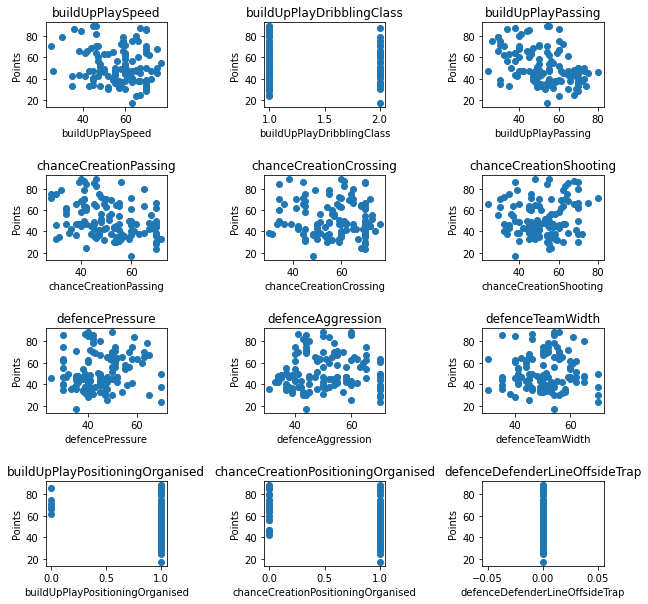

In [28]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

# Maak een scatterplot voor elke kolom in input_col
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for i, ax in enumerate(axs.flatten()):
    if i < len(input_col):
        ax.scatter(y = premier_league_attributes['Points'], x= premier_league_attributes[input_col[i]])
        ax.set_title(input_col[i])
        ax.set_xlabel(input_col[i])
        ax.set_ylabel('Points')
    else:
        ax.axis('off')

# Toon de subplot
plt.show()

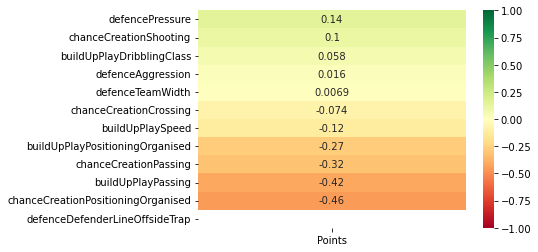

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(premier_league_attributes.corr()[['Points']].drop('Points').sort_values(by='Points', ascending = False), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
plt.show()